## Building a fully functional ANN III

Finally, this is the fully functional network!

**0) Loading and Preparing Data**

Importing libraries:

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#importing the spiral data set 
#pip install nnfs
from nnfs.datasets import spiral_data

from sklearn.metrics import confusion_matrix

<br>

Importing the spiral dataset (Nsamples for each class):

In [2]:
Nsample  = 300
Nclasses = 5
[X, Y]   = spiral_data(samples = Nsample, classes = Nclasses)

Plotting the dataset:

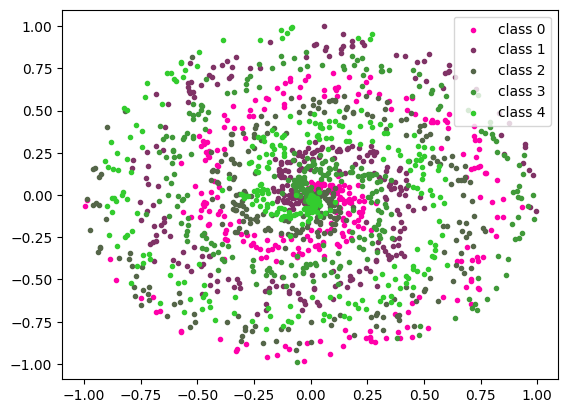

In [5]:
for n in range(Nclasses):
    idx   = np.argwhere(Y == n)[:,0]
    xplot = X[idx,0]
    yplot = X[idx,1]
    plt.scatter(xplot, yplot, marker = '.', color = [1/(n+1), n/Nclasses, 2/(2*n + 3)], label = 'class ' + str(n))
plt.legend()
plt.show()

<br>

**1) Defining all the Parts we need for an ANN**<br>
<br>
We start with defining the dense layer, including backpropagation:

In [7]:
class Layer_Dense():
    
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases  = np.zeros((1, n_neurons))
        
    def forward(self, inputs):
        self.output  = np.dot(inputs, self.weights) + self.biases
        self.inputs  = inputs

    def backward(self, dvalues):
        #gradients
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases  = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs  = np.dot(dvalues, self.weights.T)

and as well as for the activation layer.

In [9]:
class Activation_ReLU():
    
    def forward(self, inputs):
        self.output  = np.maximum(0, inputs)
        self.inputs  = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0#ReLU derivative

In [11]:
class Activation_Sigmoid():
        
    def forward(self, inputs):
        self.output = np.clip(1/(1 + np.exp(-inputs)), 1e-7, 1-1e-7)
        self.inputs = inputs

    def backward(self, dvalues):
        sigm         = self.output
        deriv        = np.multiply(sigm, (1 - sigm))#inner derivative of sigmoid
        self.dinputs = np.multiply(deriv, dvalues)

The next layers are needed for calculating the probabilities for the different classes using the Boltzmann distribution (softmax) and the loss which is the cross entropy here. 

In [13]:
class Activation_Softmax:
  
    def forward(self,inputs):
        self.inputs = inputs
        exp_values  = np.exp(inputs - np.max(inputs, axis = 1,\
                                      keepdims = True))#max in order to 
                                                       #prevent overflow
        #normalizing probs (Boltzmann dist.)
        probabilities = exp_values/np.sum(exp_values, axis = 1,\
                                      keepdims = True)  
        self.output   = probabilities                                                
    
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for i, (single_output, single_dvalues) in \
            enumerate(zip(self.output, dvalues)):
            
            single_output   = single_output.reshape(-1,1)
            jacobMatr       = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            self.dinputs[i] = np.dot(jacobMatr, single_dvalues)


class Loss:
     
     def calculate(self, output, y):
         
         sample_losses = self.forward(output, y)
         data_loss     = np.mean(sample_losses)
         return(data_loss)
    
    
class Loss_CategoricalCrossEntropy(Loss): 

     def forward(self, y_pred, y_true):
         samples = len(y_pred)
         #removing vals close to zero and one bco log and accuracy
         y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
         
         #now, depending on how classes are coded, we need to get the probs
         if len(y_true.shape) == 1:#classes are encoded as [[1],[2],[2],[4]]
             correct_confidences = y_pred_clipped[range(samples), y_true]
         elif len(y_true.shape) == 2:#classes are encoded as
                                    #[[1,0,0], [0,1,0], [0,1,0]]
             correct_confidences = np.sum(y_pred_clipped*y_true, axis = 1)
         #now: calculating actual losses
         negative_log_likelihoods = -np.log(correct_confidences)
         return(negative_log_likelihoods)
         
     def backward(self, dvalues, y_true):
         Nsamples = len(dvalues)
         Nlabels  = len(dvalues[0])
         #turning labels into one-hot i. e. [[1,0,0], [0,1,0], [0,1,0]], if
         #they are not
         if len(y_true.shape) == 1:
            y_true = np.eye(Nlabels)[y_true]
         #normalized gradient
         self.dinputs = -y_true/dvalues/Nsamples



#Creating a class as parent for softmax, loss and entropy classes. 
#Actually not neccessary, but saves code when building the ANN
class Activation_Softmax_Loss_CategoricalCrossentropy():
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss       = Loss_CategoricalCrossEntropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output#the probabilities
        #calculates and returns mean loss
        return(self.loss.calculate(self.output, y_true))
        
    def backward(self, dvalues, y_true):
        Nsamples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis = 1)
        self.dinputs = dvalues.copy()
        #calculating normalized gradient
        self.dinputs[range(Nsamples), y_true] -= 1
        self.dinputs = self.dinputs/Nsamples


Finally, we need an optimizer:

In [15]:
class Optimizer_SGD:
    #initializing with a default learning rate of 0.01
    def __init__(self, learning_rate = 0.01, decay = 0, momentum = 0):
        self.learning_rate         = learning_rate
        self.current_learning_rate = learning_rate
        self.decay                 = decay
        self.iterations            = 0
        self.momentum              = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1/ (1 + self.decay*self.iterations))
        
    def update_params(self, layer):
        
        #if we use momentum
        if self.momentum:
            
            #check if layer has attribute "momentum"
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums   = np.zeros_like(layer.biases)
                
            #now the momentum parts
            weight_updates = self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates   = -self.current_learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases  += bias_updates
        
    def post_update_params(self):
        self.iterations += 1

<br>

**2) The ANN**

As before, we call the different instances of the layers and stack them togehter to a *serial ANN* and add the backpropagation part in reverse order.

In [17]:
Nneurons1     = 128
Nsteps        = 20000 #number of iterations aka epochs
learning_rate = 0.2
decay         = 0.001
momentum      = 0.8

Nfeatures     = X.shape[1]

dense1        = Layer_Dense(Nfeatures, Nneurons1)
dense_cla     = Layer_Dense(Nneurons1, Nclasses) #for classification: Nclasses values for each data point

optimizer     = Optimizer_SGD(learning_rate = learning_rate, decay = decay, momentum = momentum)

In [19]:
ReLU            = Activation_ReLU()
Sigm            = Activation_Sigmoid()
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

<br>

The target vector is $Y$. We want to rename $Y$ in order to be consistent with our slides.

In [21]:
Target = Y

As before, we run the forward and beckward part, but now in a loop and including the optimizer and some plotting. 

In [23]:
Monitor = np.zeros((Nsteps,3)) #for storing loss, learning rate and accuracy

for epoch in range(Nsteps):
    #forward part:
    dense1.forward(X)
    ReLU.forward(dense1.output)
    dense_cla.forward(ReLU.output)
    loss = loss_activation.forward(dense_cla.output, Target)
    
    #comparing target to output
    predictions = np.argmax(loss_activation.output, axis = 1)
    accuracy    = np.mean(predictions == Target)

    
    #backward part:
    loss_activation.backward(loss_activation.output, Target)

    #loss_activation.dinputs = dL, i.e. the derivative of the loss, hence the outermost derivative
    dense_cla.backward(loss_activation.dinputs)
    ReLU.backward(dense_cla.dinputs)
    dense1.backward(ReLU.dinputs)
    
    #finally, we apply gradient descent to all learnables
    optimizer.pre_update_params()#decaying learning rate
    optimizer.update_params(dense1)
    optimizer.update_params(dense_cla)
    optimizer.post_update_params()#just increasing iteration by one
            
    Monitor[epoch,0] = accuracy
    Monitor[epoch,1] = loss
    Monitor[epoch,2] = optimizer.current_learning_rate
            
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'accuracy: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'actual learning rate: {optimizer.current_learning_rate}')

epoch: 0, accuracy: 0.193, loss: 5.301, actual learning rate: 0.2
epoch: 100, accuracy: 0.409, loss: 1.436, actual learning rate: 0.18181818181818182
epoch: 200, accuracy: 0.445, loss: 1.393, actual learning rate: 0.16666666666666669
epoch: 300, accuracy: 0.486, loss: 1.356, actual learning rate: 0.15384615384615385
epoch: 400, accuracy: 0.506, loss: 1.323, actual learning rate: 0.14285714285714288
epoch: 500, accuracy: 0.524, loss: 1.292, actual learning rate: 0.13333333333333333
epoch: 600, accuracy: 0.537, loss: 1.264, actual learning rate: 0.125
epoch: 700, accuracy: 0.550, loss: 1.239, actual learning rate: 0.1176470588235294
epoch: 800, accuracy: 0.563, loss: 1.215, actual learning rate: 0.11111111111111112
epoch: 900, accuracy: 0.572, loss: 1.195, actual learning rate: 0.10526315789473684
epoch: 1000, accuracy: 0.583, loss: 1.176, actual learning rate: 0.1
epoch: 1100, accuracy: 0.589, loss: 1.158, actual learning rate: 0.09523809523809523
epoch: 1200, accuracy: 0.594, loss: 1.1

<br>

**3) Evaluating the Fit**

a) the training process itself: 

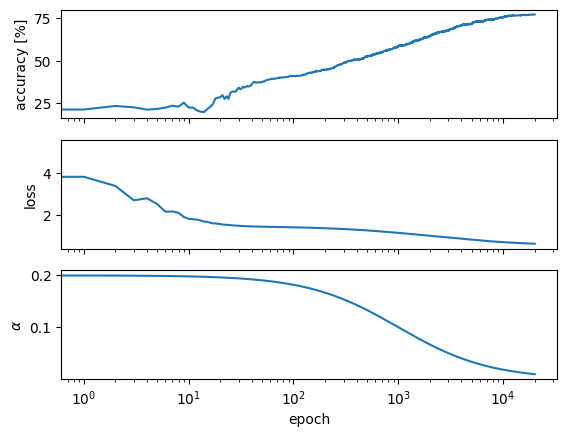

In [26]:
xplot = np.arange(Nsteps)

fig1, ax1 = plt.subplots(3, 1, sharex = True)
ax1[0].plot(xplot, 100*Monitor[:,0])
ax1[0].set_ylabel('accuracy [%]')
ax1[1].plot(xplot, Monitor[:,1])
ax1[1].set_ylabel('loss')
ax1[2].plot(xplot, Monitor[:,2])
ax1[2].set_ylabel(r'$\alpha$')
ax1[2].set_xlabel('epoch')
plt.xscale('log', base = 10)
plt.show()

b) cross entropy and confusion chart  

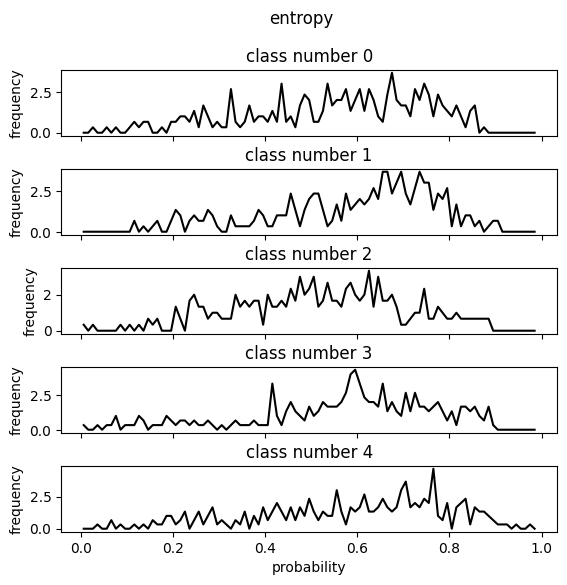

In [29]:
probabilities = loss_activation.output
ClassLabs     = np.arange(Nclasses)

fig2, ax2 = plt.subplots(Nclasses, 1, sharex = True)
fig2.set_figheight(6)
fig2.subplots_adjust(hspace = 0.5)
fig2.suptitle('entropy')
for L in ClassLabs:
    idx = np.argwhere(Target == L)[:,0]
    (value, where) = np.histogram(probabilities[idx,L],\
                                  bins = np.arange(0,1,0.01),\
                                  density = True)
    w = 0.5*(where[1:] + where[:-1])
    ax2[L].plot(w, value, 'k-')
    ax2[L].set_ylabel('frequency')
    ax2[L].set_title('class number ' + str(L))
ax2[Nclasses-1].set_xlabel('probability')
plt.show()

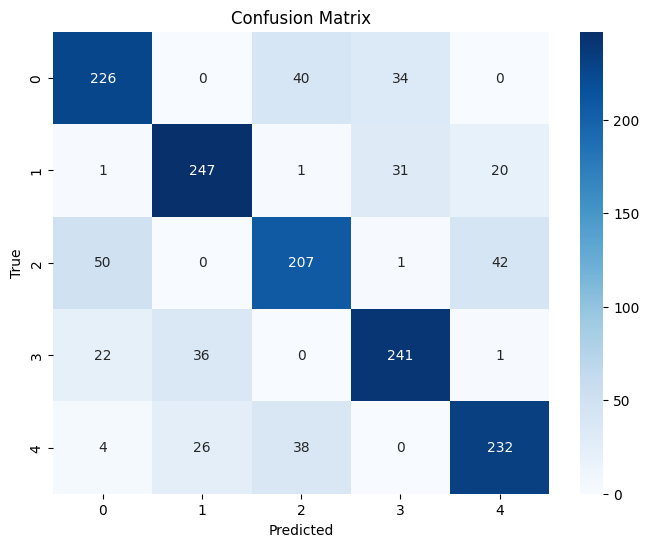

In [31]:
predicted_labels = np.argmax(probabilities, axis = 1)
cm               = confusion_matrix(Target, predicted_labels)

# Step 4: Plot confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',\
            xticklabels = ClassLabs, yticklabels = ClassLabs)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

c) plotting the predicted labels/classes vs the true labels/classes

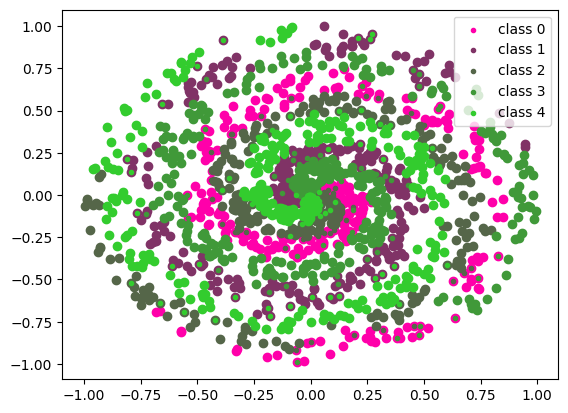

In [33]:
for n in range(Nclasses):
    idx    = np.argwhere(Y == n)[:,0]
    xplot  = X[idx,0]
    yplot  = X[idx,1]

    idxp   = np.argwhere(predicted_labels == n)[:,0]
    xplotp = X[idxp,0]
    yplotp = X[idxp,1]
    
    plt.scatter(xplot,  yplot,  marker = '.', color = [1/(n+1), n/Nclasses, 2/(2*n + 3)], label = 'class ' + str(n))
    plt.scatter(xplotp, yplotp, marker = 'o', color = [1/(n+1), n/Nclasses, 2/(2*n + 3)])
    
plt.legend()
plt.show()

Not bad for the minimal setup. Try different **numbers of neurons** for the input layer and also try different values for **momentum**, implement **L1 and L2** regularization and see how far you can improve the result! 